In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [3]:
df_repeats, df_calls = file_io.dfs_from_vcf(
    filename="../../data/banana/variants/v0.9.1/SAMEA5752290_merged_chr2_dup.vcf", 
    samples=["SAMEA5752290"], 
    vcf_format="ConSTRain"
)

subset = ["genotype", "frequencies"]
# subset = ["frequencies"]
df_calls = df_calls.dropna(subset=subset).assign(
    depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    depth_norm = lambda x: x["depth"] / x["copy_number"],
    n_distinct = lambda x: [len(set(i)) for i in x["genotype"]]
).reset_index(drop=True)

df_calls = df_calls.merge(df_repeats[["str_id", "chr", "start", "end", "period"]], on="str_id")

df_repeats.shape, df_calls.shape

((183345, 7), (153163, 12))

In [4]:
df_calls["copy_number"].value_counts()

copy_number
3    150464
4      2699
Name: count, dtype: int64

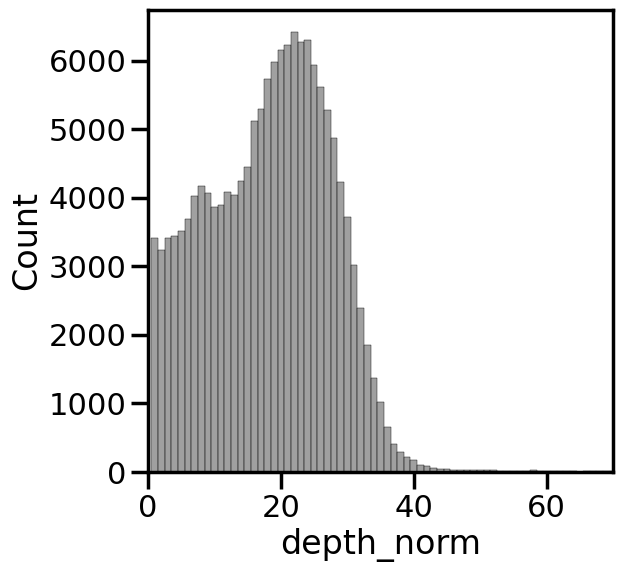

In [5]:
fig = plt.figure(figsize=(6, 6))

ax = sns.histplot(
    df_calls.query("depth_norm < 100"),
    x="depth_norm",
    discrete=True,
    color="grey"
)

_ = ax.set(
    xlim=(0, 70)
)

In [6]:
lower, upper = 1., (33 + 2/3)

print(df_calls.shape)
df_calls_filt = df_calls.query(f"depth_norm >= {lower} and depth_norm <= {upper}")
df_calls_filt.shape

(153163, 12)


(148532, 12)

In [7]:
print(df_calls_filt[df_calls_filt["n_distinct"] == 4].shape)
print(df_calls_filt[df_calls_filt["n_distinct"] == 4].query("depth_norm >= 10").shape)
# df_calls_filt[df_calls_filt["n_distinct"] == 4].query("depth_norm >= 10")


(31, 12)
(18, 12)


In [9]:
print(df_calls_filt.shape)
print(df_calls_filt["copy_number"].value_counts())
df_calls_filt[["copy_number", "n_distinct"]].groupby("copy_number", as_index=False).value_counts(["n_distinct"])

(148532, 12)
copy_number
3    145920
4      2612
Name: count, dtype: int64


,copy_number,n_distinct,count
0,3,1,80479
1,3,2,48178
2,3,3,17263
3,4,1,1362
4,4,2,907
5,4,3,312
6,4,4,31


In [10]:
df_plot = df_calls_filt[["copy_number", "n_distinct"]].groupby("copy_number", as_index=False).value_counts(["n_distinct"], normalize=True)
df_plot

,copy_number,n_distinct,proportion
0,3,1,0.551528
1,3,2,0.330167
2,3,3,0.118305
3,4,1,0.521440
4,4,2,0.347243
5,4,3,0.119449
6,4,4,0.011868


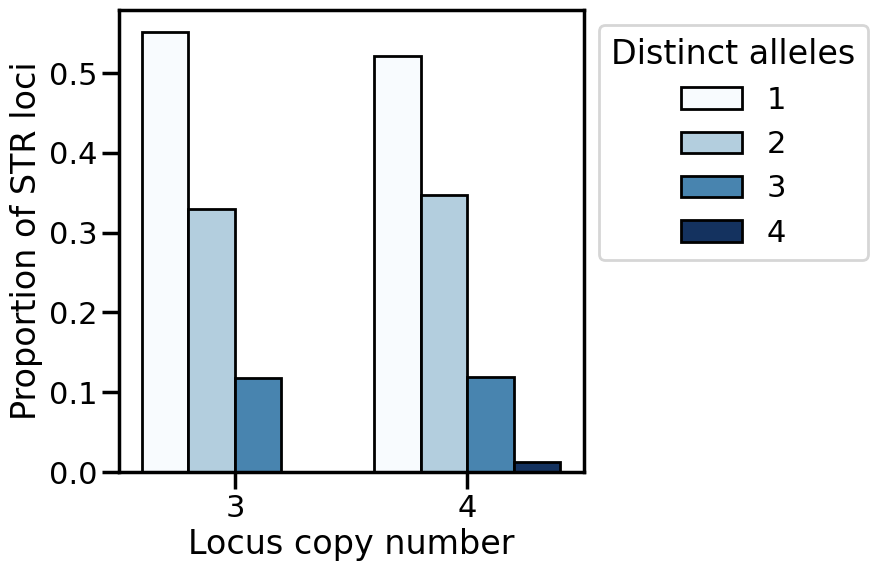

In [12]:
fig = plt.figure(figsize=(6, 6))

ax = sns.barplot(
    df_plot,
    x="copy_number",
    y="proportion",
    hue="n_distinct",
    palette="Blues",
    edgecolor="black"
)

ax.set(
    xlabel = "Locus copy number",
    ylabel = "Proportion of STR loci"
)

l = ax.get_legend()
_ = l.set(
    title = "Distinct alleles",
    bbox_to_anchor = (1, 1)
)